# CDA (Confirmatory Data Analysis)

In this notebook, we present regression results for the House dataset found on Kaggle (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). This is Part 2 of the analysis of the dataset. The notebook for Part 1 is: House Data Exploratory Analysis.

## Preliminaries (imports and function definitions)

In [1]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import explained_variance_score
import pandas as pd

# for jupyter
import sys
sys.path.append('..')

from regression_funcs.regression_plots import create_partial_plots
from house_eda_jup import price_data_preparation, transform_house_pd

%matplotlib notebook

In [2]:
def evaluate_linear_model(Xs: pd.DataFrame, y_variable: pd.Series):
    linreg = linear_model.LinearRegression()
    linreg.fit(Xs, y_variable)
    yhat = linreg.predict(Xs)
    exp_var = explained_variance_score(yhat, y_variable)

    print("Explained var:", exp_var)
    print("RSS:", np.sum((yhat - y_variable) ** 2))
    print("Coeffs:", linreg.coef_)
    print("Intercept:", linreg.intercept_)

    return linreg

## Start of Analysis

In [3]:
df = price_data_preparation('train.csv')


In [4]:
# Chosen highest R^2 variables with respect to Y (SalePrice)
primary_vars = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea']
secondary_vars = ['SalePrice', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', ]
comb_vars = np.append(primary_vars, secondary_vars[1:])

In [5]:
old_df = df.copy() # save a copy of non-transformed variables
df = transform_house_pd(df)

## Classical linear regression with transforms above

We proceed to creating various linear models. We can use the RSS to approximate the goodness of fit. The R^2 is usable to capture the total variance accounted for by the model, and the coeffs can be studied to gauge the robustness of the model changing parameters. 

### LR using all variables (primary and secondary)

In [6]:
_ = evaluate_linear_model(df[comb_vars].drop(columns=['SalePrice']), df['SalePrice'])

Explained var: 0.7704829379505013
RSS: 43.457488263883604
Coeffs: [ 4.69051355e-02  3.41440133e-01  1.06656095e-01  3.21940932e-04
  1.24872947e-02 -2.67766534e+00  3.82782272e-02 -9.14255908e-02]
Intercept: 10.031459095864728


### LR using just the primary variables

In [7]:
_ = evaluate_linear_model(df[primary_vars].drop(columns=['SalePrice']), df['SalePrice'])

Explained var: 0.7293555545597527
RSS: 49.58602343575135
Coeffs: [0.05476474 0.38215123 0.09196848 0.00082371]
Intercept: 8.356812904291997


### LR using just the secondary variables

In [8]:
_ = evaluate_linear_model(df[secondary_vars].drop(columns=['SalePrice']), df['SalePrice'])

Explained var: 0.3528933430238631
RSS: 91.46150647982618
Coeffs: [ 0.03199668 -5.78604447  0.24253577  0.41727572]
Intercept: 13.141076429183457


### LR using primary variables only & dropping outliers

<IPython.core.display.Javascript object>


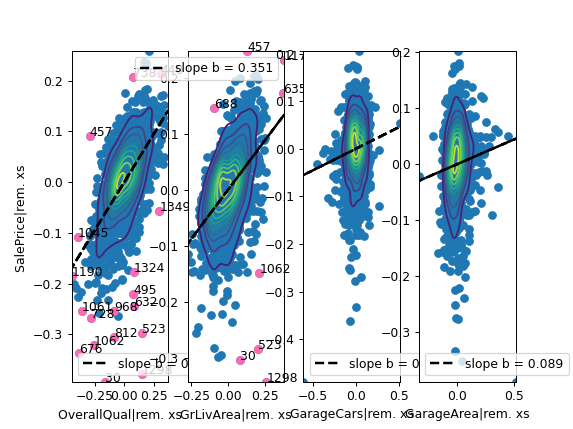

Explained var: 0.7796453127371157
RSS: 39.78280050995038
Coeffs: [0.05409747 0.39969336 0.0543086  0.00127563]
Intercept: 8.239518748237899
Outliers percentage: 1.4383561643835616%


In [9]:
outlier_idxs = create_partial_plots(df[primary_vars], 'SalePrice', drop_rows=None)
df_no_outliers = df.drop(df.index[outlier_idxs])
_ = evaluate_linear_model(df_no_outliers[primary_vars].drop(columns=['SalePrice']), df_no_outliers['SalePrice'])
print("Outliers percentage:",str((len(outlier_idxs)/df.shape[0])*100) + '%')

The plot is not neccessary to study and has been presented earlier in the EDA notebook.

Comparing this model to the previous, we find that the coefficients and the intercept do not shift by much. The RSS has reduced by about 10, hence 20% of the original RSS was a contribution from 1.43% of the total data. Additionally, the exp. variance is similar to the original model with all variables used.

### LR using primary variables, dropping outliers found in the (first 2 components of the)  PCA 'space'

In [10]:
df_no_outliers = df.drop(df.index[[1298, 440, 523, 1190, 1061]])
_ = evaluate_linear_model(df_no_outliers[primary_vars].drop(columns=['SalePrice']), df_no_outliers['SalePrice'])

Explained var: 0.749744915058683
RSS: 46.20180856334429
Coeffs: [0.0550379  0.39874675 0.05424603 0.00124799]
Intercept: 8.235885512547615


There is not much interesting about this result. Dropping some outliers lowered the RSS slightly, and increased the explained variance.

###  LR using all variables, dropping outliers

<IPython.core.display.Javascript object>


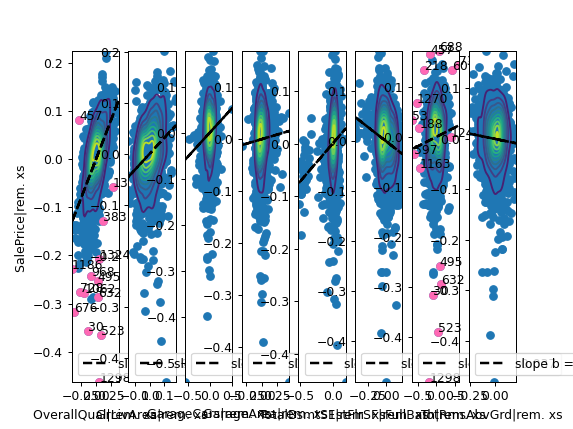

Explained var: 0.8220447056804724
RSS: 33.395784361134616
Coeffs: [ 4.59823028e-02  3.56432726e-01  7.06069155e-02  6.89489635e-04
  1.43684648e-02 -2.54476733e+00  4.01421710e-02 -7.53679592e-02]
Intercept: 9.811650936022971


In [11]:
outlier_idxs = create_partial_plots(df[comb_vars], 'SalePrice', drop_rows=None)
df_no_outliers = df.drop(df.index[outlier_idxs])
_ = evaluate_linear_model(df_no_outliers[comb_vars].drop(columns=['SalePrice']), df_no_outliers['SalePrice'])

The plot can be avoided once more.

### Findings

Concerning linear regression, the aim generally is to find predictors linearly correlated to the dependant variable, but not being collinear themselves. Hence, the diagnostics plays a huge role when it comes to model fitting. There is not much to find here except the obvious - the decrease of RSS with the removal of outliers, likewise the increased in explained variance. We found that the coeffs do not change by much by including or excluding outliers, probably due to the abundance of datapoints (1460). 

All in all the most complicated model (the immediate previous), yields 82% of explained variance, and an RSS of 33 relative to 43 (the original model with all variables). Thus again 1.43% of the data has removed 20% of the RSS. 

## Future Work

If we look at the EDA analysis, we have found particular non-linearities within some primary variables and all of the secondary variables. We have not experimented with correcting such non-monotonic non-linearities. 

Additionally, we found three clusters via PCA. Future work may entail fitting seperate models for each cluster.